In [189]:
#导入Pandas
import pandas as pd
#导入金融数据获取模块datareader
import pandas_datareader.data as web
#导入numpy
import numpy as np

In [190]:
#首先我们来定义一个函数，用来获取数据
#传入的三个参数分别是开始日期，结束日期和输出的文件名
def load_stock(start_date, end_date, output_file):
    #首先让程序尝试读取已下载并保存的文件
    try:
        df = pd.read_pickle(output_file)
        #如果文件已存在，则打印载入股票数据文件完毕
        print('载入股票数据文件完毕')
    #如果没有找到文件，则重新进行下载
    except FileNotFoundError:
        print('文件未找到，重新下载中')
        #这里制定下载中国平安（601318）的交易数据
        #下载源为yahoo
        df = web.DataReader('601318.SS','yahoo', start_date, end_date)
        #下载成功后保存为pickle文件
        df.to_pickle(output_file)
        #并通知我们下载完成
        print('下载完成')
    #最后将下载的数据表进行返回
    return df

In [191]:
#下面使用我们定义好的函数来获取中国平安的交易数据
#获取三年的数据，从2017年3月9日至2020年的3月5日
#保存为名为601318的pickle文件
zgpa = load_stock(start_date = '2017-03-09', 
                  end_date = '2020-03-05',
                 output_file = '601318.pkl')

载入股票数据文件完毕


In [192]:
#可以检查一下数据的前五行
zgpa.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2017-03-09,35.799999,35.500000,35.770000,35.779999,37796652.0,33.418541
2017-03-10,35.770000,35.580002,35.709999,35.599998,20744676.0,33.250423
2017-03-13,36.040001,35.560001,35.599998,35.970001,35999002.0,33.596004
2017-03-14,36.130001,35.810001,35.990002,35.939999,27696420.0,33.567982
2017-03-15,36.000000,35.759998,35.880001,35.959999,26872050.0,33.586662


In [193]:
#下面我们来定义一个用于分类的函数，给数据表增加三个字段
#首先是开盘价减收盘价，命名为‘Open-Close’
#其次是最高价减最低价，命名为‘High-Low’
def classification_tc(df):
    df['Open-Close'] = df['Open'] - df['Close']
    df['High-Low'] = df['High'] - df['Low']
    #在添加一个target字段，如果次日收盘价高于当日收盘价，则标记为1，反之为-1
    df['target'] = np.where(df['Close'].shift(-1)>df['Close'], 1, -1)
    #去掉有空值的行
    df = df.dropna()
    #将‘Open-Close’和‘High-Low’作为数据集的特征
    X = df[['Open-Close', 'High-Low']]
    #将target赋值给y
    y = df['target']
    #将X与y进行返回
    return(X,y)

In [194]:
#下面定义一个用于回归的函数
#特征的添加和分类函数类似
#只不过target字段改为次日收盘价减去当日收盘价
def regression_tc(df):
    df['Open-Close'] = df['Open'] - df['Close']
    df['High-Low'] = df['High'] - df['Low']
    df['target'] = df['Close'].shift(-1) - df['Close']
    df = df.dropna()
    X = df[['Open-Close', 'High-Low']]
    y = df['target']
    #将X和y进行返回
    return(X,y)

In [195]:
#导入数据集拆分工具train_test_split
from sklearn.model_selection import train_test_split
#使用train_test_split定义一个拆分数据集的函数，默认训练集占比80%
def split_data(X, y, train_size=0.8):
    #将拆分结果进行返回
    return train_test_split(X, y, shuffle=False, train_size=train_size)

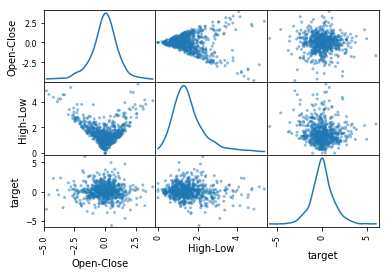

In [196]:
#可以简单地对我们添加的特征进行可视化
#首先是用刚才定义好的函数来处理一下原始数据
X, y = regression_tc(zgpa)
#使用散点图矩阵来进行可视化
pd.plotting.scatter_matrix(zgpa[['Open-Close','High-Low','target']], 
                           diagonal='kde')
#显示图像
plt.show()

In [197]:
#将数据集拆分为训练集和验证集，训练集占比80%
X_train, X_test, y_train, y_test = split_data(X, y, train_size=0.8)

In [198]:
#导入线性回归模型
from sklearn.linear_model import LinearRegression
#创建一个线性回归实例
reg = LinearRegression()
#并拟合训练集
reg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [199]:
#导入模型评分工具R2和MSE
from sklearn.metrics import r2_score, mean_squared_error
#将模型在训练集和验证集的得分进行打印
print('训练集中的R2分数:%.2f'%r2_score(y_train, reg.predict(X_train)))
print('验证集中的R2分数:%.2f'%r2_score(y_test, reg.predict(X_test)))
print('训练集的MSE:%.2f'%mean_squared_error(y_train, reg.predict(X_train)))
print('验证集的MSE:%.2f'%mean_squared_error(y_test, reg.predict(X_test)))

训练集中的R2分数:0.02
验证集中的R2分数:-0.03
训练集的MSE:1.58
验证集的MSE:1.27


In [200]:
#下面我们来对策略进行评估
#先保证数据集中没有空值
zgpa = zgpa.dropna()
#使用线性回归模型预测次日股票的涨跌幅
zgpa['Predict_Signal'] = reg.predict(X)
#在数据集中添加一个字段，用当日收盘价除以前一日收盘价，并取其自然对数
zgpa['zgpa_Return'] = np.log(zgpa['Close']/zgpa['Close'].shift(1))
#定义一个计算回报的函数
def calculate_return(df, split_value, symbol):
    #该股票基准收益为‘zgpa_Return’的总和*100
    cum_zgpa_return = df[split_value:]['%s_Return'%symbol].cumsum()*100
    #将计算结果进行返回
    return cum_zgpa_returns
#再定义一个计算使用策略交易的收益
def strategy_return(df, split_value, symbol):
    #使用策略交易的收益为模型‘zgpa_Return’乘以模型预测的涨跌幅
    df['Strategy_Return'] = df['%s_Return'%symbol]*df['Predict_Signal'].shift(1)
    #将每日策略交易的收益加和并乘以100
    cum_strategy_return = df[split_value:]['Strategy_Return'].cumsum()*100
    #将计算结果进行返回
    return cum_strategy_return
#使用定义好的函数来计算中国平安的基准收益
cum_zgpa_return = calculate_return(zgpa, split_value=len(X_train), symbol='zgpa')
#查看一下计算结果
cum_zgpa_return

Date
2019-07-29    -0.724037
2019-07-30    -0.133269
2019-07-31    -2.256117
2019-08-01    -2.916705
2019-08-02    -4.622409
                ...    
2020-02-28   -14.780751
2020-03-02   -12.415732
2020-03-03   -12.528895
2020-03-04   -11.166965
2020-03-05    -8.872814
Name: zgpa_Returns, Length: 146, dtype: float64

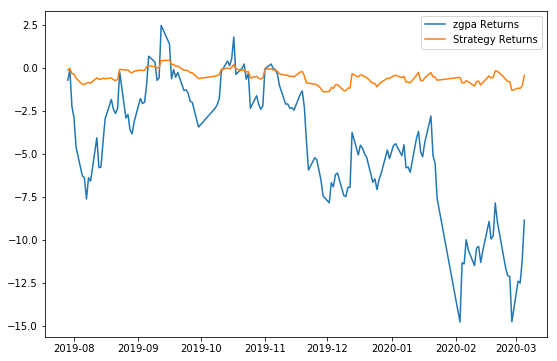

In [201]:
#使用定义好的函数计算算法交易的收益
cum_strategy_return = strategy_return(zgpa,split_value=len(X_train), symbol='zgpa')
#定义一个绘图函数，用来对比基准收益和算法交易的收益
def plot_chart(cum_symbol_return, cum_strategy_return, symbol):
    #首先是定义画布的尺寸
    plt.figure(figsize=(9,6))
    #使用折线图绘制基准收益
    plt.plot(cum_symbol_return, label='%s Returns'%symbol)
    #使用折线图绘制算法交易收益
    plt.plot(cum_strategy_return, label = 'Strategy Returns')
    #添加图注
    plt.legend()
    #显示图像
    plt.show()
#使用该函数绘制中国平安的收益对比图
plot_chart(cum_zgpa_return, cum_strategy_return, symbol='zgpa')

In [202]:
#定义一个计算夏普指数的函数
def sharpe_ratio(symbol_return, strategy_return):
    #使用.std()计算出算法交易收益的标准差
    strategy_std = strategy_return.std()
    #夏普指数为（算法交易收益-基准收益）/算法交易收益的标准差
    sharpe = (strategy_return - symbol_return)/strategy_std
    #返回计算结果的均值
    return sharpe.mean()
#打印模型交易的夏普指数
print(sharpe_ratio(cum_zgpa_return, cum_strategy_return))

10.040527666665069


In [203]:
#导入套索回归和岭回归
from sklearn.linear_model import Lasso, Ridge

In [204]:
#创建一个alpha为10的套索回归实例
lasso = Lasso(alpha = 10)
#拟合训练集
lasso.fit(X_train, y_train)
#查看模型在验证集的R2分数
lasso.score(X_test, y_test)

-0.018559508744974806

In [205]:
#创建一个alpha参数为100000的岭回归实例
#并拟合训练集
ridge = Ridge(alpha=100000).fit(X_train, y_train)
#查看模型在验证集的R2分数
ridge.score(X_test, y_test)

-0.01857827337693707

In [206]:
#导入决策树回归模型
from sklearn.tree import DecisionTreeRegressor

In [207]:
#创建一个决策树回归实例
#并拟合训练集
dt = DecisionTreeRegressor().fit(X_train, y_train)
#查看模型在验证集中的分数
dt.score(X_test, y_test)

-1.3972363016275486

===使用分类算法===

In [208]:
#使用classification_tc函数生成数据集的特征与目标
X, y = classification_tc(zgpa)
#将数据集拆分为训练集与验证集
X_train, X_test, y_train, y_test =\
split_data(X, y, train_size=0.8)

In [209]:
#导入KNN
from sklearn.neighbors import KNeighborsClassifier

In [210]:
#创建一个knn实例，n_neighbors取10
knn = KNeighborsClassifier(n_neighbors=10)
#使用knn拟合训练集
knn.fit(X_train, y_train)
#打印模型在训练集中的准确率
print(knn.score(X_train, y_train))
#打印模型在验证集中的准确率
print(knn.score(X_test, y_test))

0.6327586206896552
0.5


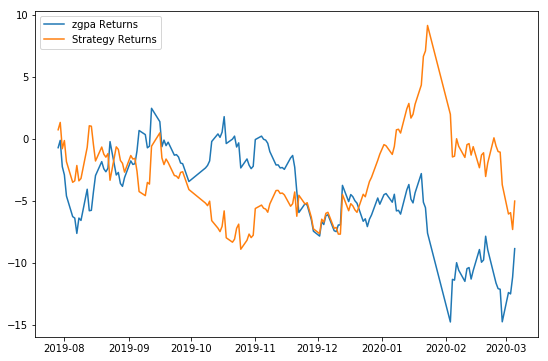

In [211]:
#首先还是确保数据中没有空值
zgpa=zgpa.dropna()
#使用knn进行预测，并写入到‘Predict_Signal’字段
zgpa['Predict_Signal'] = knn.predict(X)
#计算基准收益
cum_zgpa_return = calculate_return(zgpa, split_value=len(X_train), symbol='zgpa')
#计算算法交易的收益
cum_strategy_return = strategy_return(zgpa, 
                                                split_value=len(X_train),
                                     symbol='zgpa')
#使用图形进行对比
plot_chart(cum_zgpa_return, cum_strategy_return, symbol='zgpa')

In [212]:
#导入支持向量机分类器SVC
from sklearn.svm import SVC

In [213]:
#创建SVC实例
svc = SVC(gamma='auto')
#拟合训练集
svc.fit(X_train, y_train)
#打印模型在训练集中的准确率
print(svc.score(X_train, y_train))
#打印模型在验证集中的准确率
print(svc.score(X_test, y_test))

0.5758620689655173
0.4931506849315068


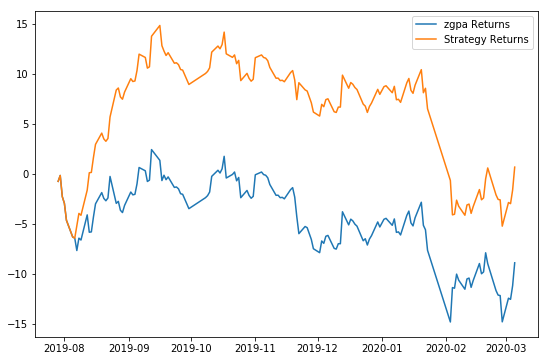

In [214]:
#同样使用图像来对比模型收益和基准收益
zgpa['Predict_Signal'] = svc.predict(X)
cum_zgpa_return = calculate_return(zgpa, split_value=len(X_train), symbol='zgpa')
cum_strategy_return = strategy_return(zgpa, 
                                                split_value=len(X_train),
                                     symbol='zgpa')
plot_chart(cum_zgpa_return, cum_strategy_return, symbol='zgpa')

In [215]:
#导入逻辑回归
from sklearn.linear_model import LogisticRegression

In [216]:
#创建逻辑回归实例
lr = LogisticRegression(solver='lbfgs')
#拟合训练集
lr.fit(X_train, y_train)
#分别打印模型在训练集与验证集中的准确率
print(lr.score(X_train, y_train))
print(lr.score(X_test, y_test))

0.5655172413793104
0.4657534246575342


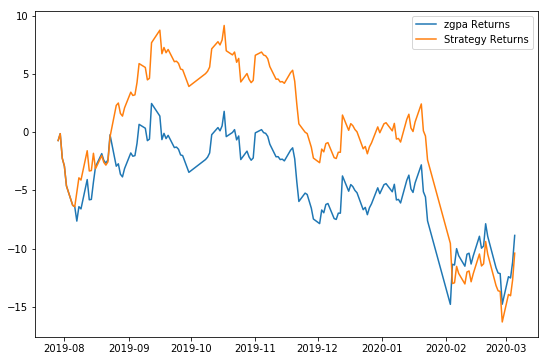

In [217]:
#使用图像对比逻辑回归模型的收益和基准收益
zgpa['Predict_Signal'] = lr.predict(X)
cum_zgpa_return = calculate_return(zgpa, split_value=len(X_train), symbol='zgpa')
cum_strategy_return = strategy_return(zgpa, 
                                                split_value=len(X_train),
                                     symbol='zgpa')
plot_chart(cum_zgpa_return, cum_strategy_return, symbol='zgpa')